# Fourier Space and Telescopes
In this notebook, we'll go over the basics of Fourier Transforms and how you can achieve them using `numpy`. We'll go from 1D transforms to 2D transforms, look at how these transformations naturally happen in a lens/dish telescope, and how we can use them to form images from an interferometer.

## Basics of Fourier Transforms
Fourier transforms can be tricky to get your head around, and can be defined with a number of different normalisations. For that reason, I'm going to have to cover a chunk of theory here for it to make sense to you if you are new to them. So bear with me, and let's begin!

A fourier transform (FT) is a way of decomposing a time varying signal into a number of sinusoidal waves that when combined, approximate the original time varying signal. The mathematical definition of the FT, $F(a)$, of the function $f(x)$ can be expressed as:

\begin{equation*}
F(a) = \int_{-\infty}^\infty f(x) \exp(-2 \pi i ax) dx
\end{equation*}

The units of the variable $a$ are always the inverse of $x$. So if you have a time-varying function, say $f(t)$ with $t$ in seconds, you end up with $F(\nu)$, where $\nu$ is a frequency with units s$^{-1}$. Hence how applying the Fourier transform to a time-varying signal gives us back the frequencies.

Aight, enough talk, let's code. `numpy` has a numerical implementation (and so an approximation to the integral form) of the FT in `numpy.fft` (check out documentation [here](https://numpy.org/doc/stable/reference/routines.fft.html)). The most simple example possible is to fourier transform a single sine wave. First off, let's make a sine wave:

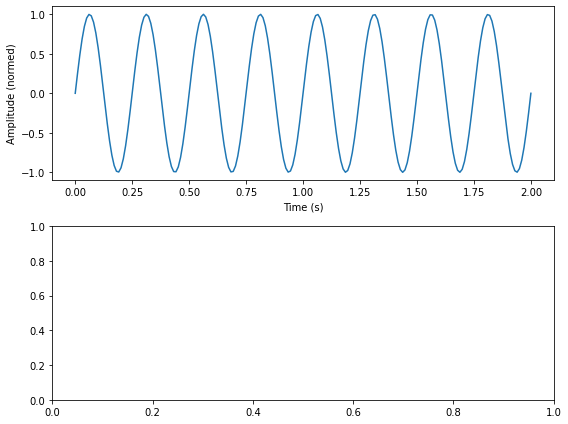

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

##Let's cheat, and make a sine wave with a known frequency
freq = 4

##Set up some time samples to sample our wave at
time_samps = np.linspace(0,2,200)

##Make the wave
sine_wave = np.sin(2*np.pi*time_samps*freq)

##Plot top half of plot
fig, axs = plt.subplots(2,1,figsize=(8,6))

axs[0].plot(time_samps, sine_wave)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude (normed)')

plt.tight_layout()
plt.show()

Ok, so the range of frequencies $\nu$ that we can sample are dictated by how often we sample in time. As $t$ and $\nu$ are the inverse of one another, the sample rate in time, $\Delta t$ sets the maximum frequency $\nu_{\mathrm{max}}$ we can infer like:

\begin{equation*}
\nu_{\mathrm{max}} = \frac{1}{\Delta t}
\end{equation*}

Similarly, the smallest change in frequency we can sample is set by the duration we sample over:

\begin{equation*}
\Delta \nu = \frac{1}{t_{\mathrm{max}}}
\end{equation*}

We need these relationships to calculate what frequencies have been sampled by our Fourier transform. `numpy` has a helper function to do these calculations, called `fft.fftfreq`. We'll use it and `fft.fft` to do FT our sine wave:

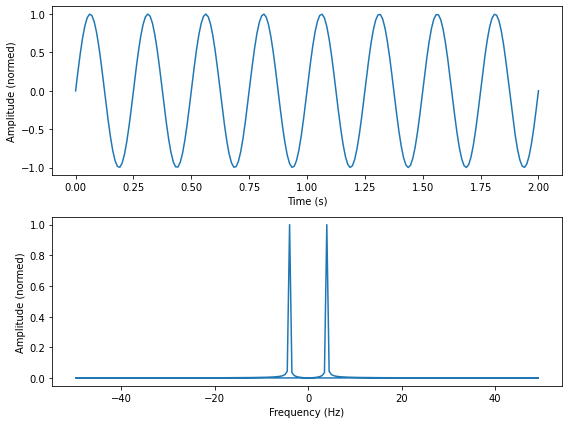

In [2]:
##Do the fourier transform
ft_sine_wave = np.fft.fft(sine_wave) 

##I'm going to normalise so that the maximum
##is set to 1.0. We'll take about proper normalisatiom
##later in the notebook

ft_sine_wave /= max(np.abs(ft_sine_wave))

##We need the time resolution to work out the sampled frequencies
time_res = time_samps[1] - time_samps[0]

##Uses the number of samples and sampling resolution
##to calculate the inverse coords (frequencies) sampled
ft_frequencies = np.fft.fftfreq(len(sine_wave),time_res)

##Plot the whole plot
fig, axs = plt.subplots(2,1,figsize=(8,6))

axs[0].plot(time_samps, sine_wave)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude (normed)')


axs[1].plot(ft_frequencies, abs(ft_sine_wave))
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Amplitude (normed)')

plt.tight_layout()
plt.show()

Riiight, so we have *two* peaks here, and wut? Negative frequencies? Also, why have you taken plotted `abs(ft_sine_wave)` instead of just `ft_sine_wave`? This is too complicated to really cover here, but it's because the FT uses imaginary numbers, so `numpy` makes your data complex, and negative frequencies are a natural consequence. Depending on *what* original signal you are transforming, you can often ignore the negative freqs, as they are just a mirror of the positive ones. So let's do that here. Because I said so.

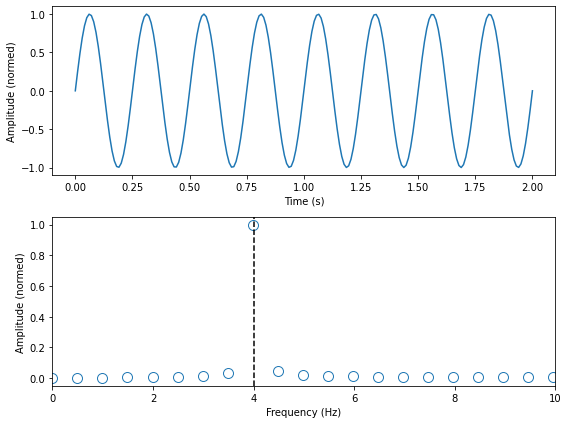

In [3]:
##Plot the whole plot
fig, axs = plt.subplots(2,1,figsize=(8,6))

axs[0].plot(time_samps, sine_wave)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude (normed)')

##Change to plotting circles
axs[1].plot(ft_frequencies, abs(ft_sine_wave),'C0o',mfc='none',ms=10)
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Amplitude (normed)')

##set to look at interesting range
axs[1].set_xlim(0,10)

##This plots a vertical line at our wave frequency
axs[1].axvline(freq,linestyle='--',color='k')

plt.tight_layout()
plt.show()

Hooray! We have successfully FT'd our input sine wave, and found the exact frequency that we expected.

There is one more thing to get your head around here, and that's the order in which `numpy` outputs the FT frequencies. If we just plot the frequencies in their natural order we get this:

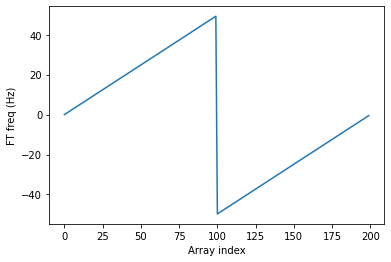

In [4]:
##Plot just the FT frequencies
plt.plot(ft_frequencies)
plt.xlabel('Array index')
plt.ylabel('FT freq (Hz)')
plt.show()

The default in `numpy` is to return the zero frequency at index 0, followed by the positive frequencies, then the negative frequencies. Note the zero frequency is often called the 'DC component'. While this order is totally fine, it's often more intuitive to have zero frequency at the centre. There is another helper function that does this shift for you, called `np.fft.fftshift`, which you can wrap you outputs in. Check out the below to see what it does:

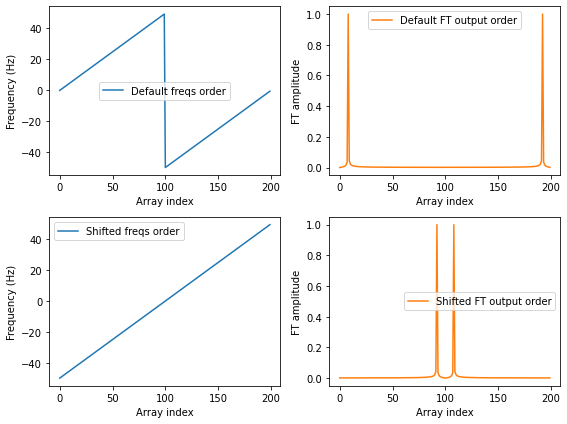

In [5]:
##Setup figure
fig, axs = plt.subplots(2,2,figsize=(8,6))

##wrap the FT fequencies AND result in np.fft.fftshift
sorted_freqs = np.fft.fftshift(ft_frequencies)
sorted_FT = np.fft.fftshift(ft_sine_wave)

##Plot to compare with the old ordering
axs[0,0].plot(ft_frequencies, 'C0-', label='Default freqs order')
axs[0,1].plot(np.abs(ft_sine_wave), 'C1-', label='Default FT output order')

axs[1,0].plot(sorted_freqs, 'C0-', label='Shifted freqs order')
axs[1,1].plot(np.abs(sorted_FT), 'C1-', label='Shifted FT output order')

##Labels labels labels
for ax in axs.flatten():
    ax.set_xlabel('Array index')
    ax.legend()
    
for ax in axs[:,0]:
    ax.set_ylabel('Frequency (Hz)')

for ax in axs[:,1]:
    ax.set_ylabel('FT amplitude')

plt.tight_layout()
plt.show()

## <font color='blue'>Ex 5.1 </font>
Ok, let's consolidate what we've just covered. Make a sine wave with a frequency of 8Hz, and FT, making sure you recover the correct frequency. Use `np.fft.fftfreq` to find the FT freqs, and reorder your outputs using `np.fft.fftshift`.

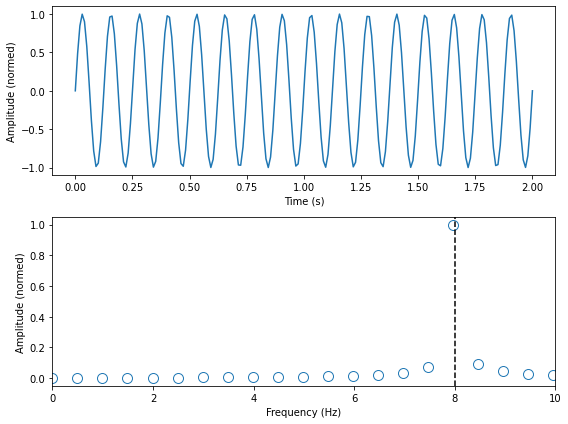

In [6]:
freq = 8
##Set up some time samples to sample our wave at
time_samps = np.linspace(0,2,200)

##Make the wave
sine_wave = np.sin(2*np.pi*time_samps*freq)

##Do the fourier transform, and shift it to have
##the zero frequency at the centre, all in one line
ft_sine_wave = np.fft.fftshift(np.fft.fft(sine_wave))

##I'm going to normalise so that the maximum
##is set to 1.0. We'll take about proper normalisatiom
##later in the notebook
ft_sine_wave /= max(np.abs(ft_sine_wave))

##We need the time resolution to work out the sampled frequencies
time_res = time_samps[1] - time_samps[0]

##Uses the number of samples and sampling resolution
##to calculate the inverse coords (frequencies) sampled
##Again, reorder to have the central zero frequency
ft_frequencies = np.fft.fftshift(np.fft.fftfreq(len(sine_wave),time_res))

##Plot the whole plot
fig, axs = plt.subplots(2,1,figsize=(8,6))

axs[0].plot(time_samps, sine_wave)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude (normed)')

##Change to plotting circles
axs[1].plot(ft_frequencies, abs(ft_sine_wave),'C0o',mfc='none',ms=10)
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Amplitude (normed)')

##set to look at interesting range
axs[1].set_xlim(0,10)

##This plots a vertical line at our wave frequency
axs[1].axvline(freq,linestyle='--',color='k')

plt.tight_layout()
plt.show()

## Combined signal decomposition
If you have a time varying signal that is the product of multiple processes, each with their own frequency, you can use an FT to pull that signal apart and ascertain those frequencies. Let's make a combined wave, and the pull it apart into multiple signals here:

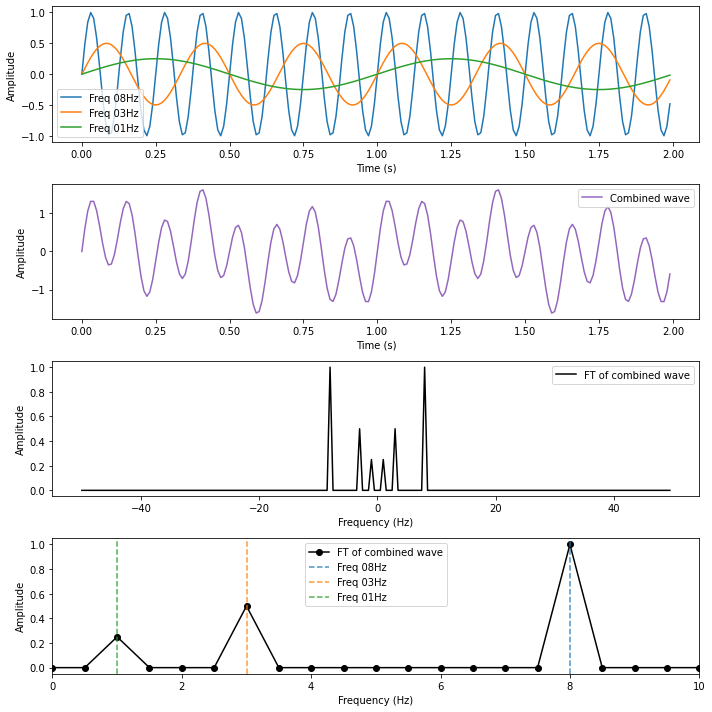

In [7]:
##Code adapted from this site, all credit to original author:
##https://pythontic.com/visualization/signals/ft_combined_wave_fft

import numpy as np
import matplotlib.pyplot as plt

##Setup time sampling
time_interval = 2
time_res = 0.01
time_samps = np.arange(0,time_interval,time_res)

##Use the frequencies
freq1 = 8
freq2 = 3
freq3 = 1

##Give each wave a different amplitude
amp1 = 1
amp2 = 0.5
amp3 = 0.25

##Create the component waves
sine1 = amp1*np.sin(2*np.pi*time_samps*freq1)
sine2 = amp2*np.sin(2*np.pi*time_samps*freq2)
sine3 = amp3*np.sin(2*np.pi*time_samps*freq3)

##combine components into one wave
combined_wave = sine1 + sine2 + sine3
##do the FT
ft_combined_wave = np.fft.fftshift(np.fft.fft(combined_wave))

##Again, normalise the output, just by the maximum of the amplitude
ft_combined_wave /= max(np.abs(ft_combined_wave))

##Uses the number of samples and sampling resolution
##to calculate the inverse coords (frequencies) sampled
ft_frequencies = np.fft.fftshift(np.fft.fftfreq(len(ft_combined_wave),time_res))

##Plot plots plots
fig, axs = plt.subplots(4,1,figsize=(10,10))

axs[0].plot(time_samps, sine1, label='Freq %02dHz' %freq1)
axs[0].plot(time_samps, sine2, label='Freq %02dHz' %freq2)
axs[0].plot(time_samps, sine3, label='Freq %02dHz' %freq3)

axs[1].plot(time_samps, combined_wave, 'C4-', label='Combined wave')

for ax in axs[:2]:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')

axs[2].plot(ft_frequencies, np.abs(ft_combined_wave), 'k-', label='FT of combined wave')
axs[3].plot(ft_frequencies, np.abs(ft_combined_wave), 'k-o', label='FT of combined wave')
axs[3].set_xlim(0,10)

##The axvline plots a vertical line at a given x coord that spans the whole plot. Handy!
axs[3].axvline(freq1,linestyle='--',alpha=0.8,color='C0', label='Freq %02dHz' %freq1)
axs[3].axvline(freq2,linestyle='--',alpha=0.8,color='C1', label='Freq %02dHz' %freq2)
axs[3].axvline(freq3,linestyle='--',alpha=0.8,color='C2', label='Freq %02dHz' %freq3)

for ax in axs[2:]:
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitude')

for ax in axs:
    ax.legend()

plt.tight_layout()
plt.show()

## <font color='blue'>Ex 5.2 </font>
Along with this notebook, there should be a text file named `mystery_signal.txt`, which contains two columns, time samples vs freqs. This data is another time-varying wave, containing multiple component frequencies. Read in the data, and find the frequency of the components of this combined wave. By taking the FT and investigating the output, it should be clear how many components there are - try to find a way of printing out the frequencies that you identify. <font color='red'>Optional extension - also print out the relative amplitudes of the components.</font>

Wave frequencies are [ 1.996 12.974 16.966 19.96 ]
Wave amplitudes are [1.         0.49643778 0.24263716 0.09184724]


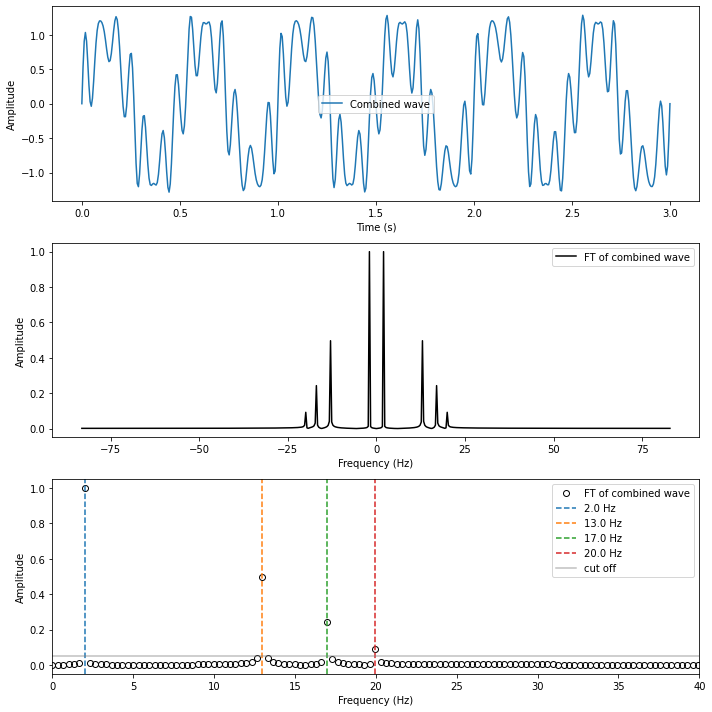

In [44]:
###=====================================================
##Here I'm actually making the data "mystery_signal.txt"
time_interval = 3.0
time_samps = np.linspace(0,time_interval,500)

freqs = [2, 13, 17, 20]
amps = [1, 0.5, 0.25, 0.1]

##empty numpy array to initialise combined_wave
combined_wave = np.zeros(len(combined_wave))

##for each amp, freq, add a wave component
for amp, freq in zip(amps, freqs):
    combined_wave += amp*np.sin(2*np.pi*time_samps*freq)

##package up the data and save to a text file
save_array = np.empty((len(combined_wave),2))
save_array[:,0] = time_samps
save_array[:,1] = combined_wave
np.savetxt('mystery_signal.txt',save_array)

###=====================================================

##Load in the data 
data = np.loadtxt('mystery_signal.txt')

loaded_times = data[:,0]
loaded_wave = data[:,1]

##Find the time resolution
time_res = loaded_times[1] - loaded_times[0]

##Do FT and just normalise by max abs value
ft_loaded_wave = np.fft.fftshift(np.fft.fft(loaded_wave))
ft_loaded_wave /= max(abs(ft_loaded_wave))

##Uses the number of samples and sampling resolution
##to calculate the inverse coords (frequencies) sampled
ft_frequencies = np.fft.fftshift(np.fft.fftfreq(len(ft_loaded_wave),time_res))



##I'm going to set a cutoff value as to what counts as a
##measured FT frequency amplitude. To do this rigorously you could
##use something like scipy.signal.find_peaks:
##https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

##Instead, I've plotted the data, found a sensible amplitude cutoff
##and applied that
upper = 0.05

##Apply the cutoff, and only consider positive FT frequencies
abs_values = abs(ft_loaded_wave)
measured_freqs = ft_frequencies[(abs_values > upper) & (ft_frequencies > 0)]
measured_amps = abs_values[(abs_values > upper) & (ft_frequencies > 0)]

##Print our results
print("Wave frequencies are",measured_freqs )
print("Wave amplitudes are",measured_amps )

##Plot the results
fig, axs = plt.subplots(3,1,figsize=(10,10))

axs[0].plot(loaded_times, loaded_wave, label='Combined wave')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')


axs[1].plot(ft_frequencies, abs(ft_loaded_wave), 'k-', label='FT of combined wave')
axs[2].plot(ft_frequencies, abs(ft_loaded_wave), 'ko', mfc='none', label='FT of combined wave')


for ind, freq in enumerate(measured_freqs):
    axs[2].axvline(freq,color='C{:d}'.format(ind),linestyle='--',label='{:.1f} Hz'.format(freq))

axs[2].set_xlim(0,40)

##Plot a horizontal line where below which I discarded the results
##when selected which frequencies we have measured
axs[2].axhline(upper,color='gray',alpha=0.5,label='cut off')

for ax in axs[1:]:
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitude')

for ax in axs:
    ax.legend()

plt.tight_layout()
# #fig.savefig('fourier_transforms.png',bbox_inches='tight')
plt.show()

## Known FT pairs and normalisation
There are many functions that have a known functional solution to their Fourier Transform. These functions are great because you can make an analytic prediction of an FT without having to spend the computing power of actually doing the FT. They also serve as a way of checking any script that you write to perform an FT is working correctly. There is an exhaustive list of known FTs [here](https://en.wikipedia.org/wiki/Fourier_transform#Tables_of_important_Fourier_transforms). We'll look at one of the the basics functions we've seen before - the 'tophat' function (which is also known as the 'boxcar' function, or the 'rect' function on wikipedia).

Let's call it a `rect` function, which we'll define as:

\begin{equation}
\mbox{rect}(x) =
\left\{
	\begin{array}{ll}
		1  & \mbox{if } |x| <= \frac{1}{2} \\
		0 & \mbox{if } |x| > \frac{1}{2}
	\end{array}
\right.
\end{equation}

If you FT a `rect` function, you get what's called a `sinc` function, which we'll define as

\begin{equation}
\mbox{sinc}(x) = \frac{\sin(\pi x)}{\pi x}
\end{equation}

Turns out `numpy` already has a built in sinc function, so we'll use `np.sinc`. For clarity we'll define our own `rect` function. In the code below, I'll make a `rect` function, and FT it. I'll also discuss some normalisation issues, and compare the FT outcome with a `sinc` prediction.

DC term compared to calculated norm (20+0j) 20.0


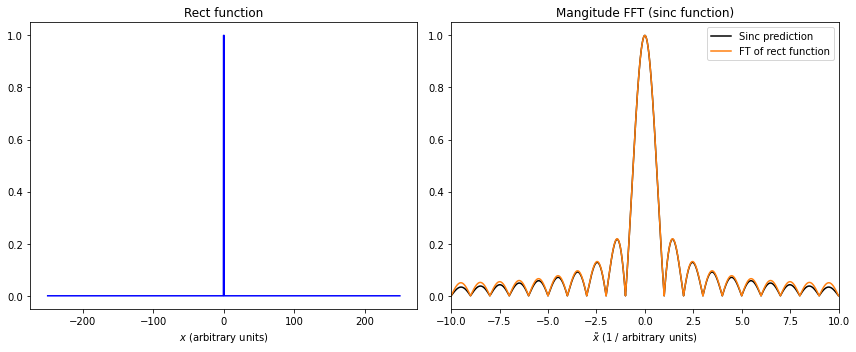

In [9]:
def rect(x, r=0.5):
    '''Creates a rect function for given x coords, where:
    rect(x) = 1 if x <= r/2
    rect(x) = 0 if x > r/2
    
    r defaults to 0.5'''
    out = np.zeros(len(x))
    out[abs(x) <= r] = 1.0
    return out

##Setup some sampling coords
num_samps = 10000
span = 500
reso = span / num_samps
coords = np.arange(-span/2, span/2, reso)

##Make the tophat (or rect) output
tophat = rect(coords)

##FT out tophat
fft_tophat = np.fft.fft(tophat)

##We know by definition that a rect function as defined above,
##should return a sinc function with an amplitude of 1.0
##at maximum. Due to the implementation of np.fft, we normalise
##in this case using the number of samples and coord span like this
norm = num_samps / span

##Find the DC term  (the zero frequency)
dc_term = fft_tophat[0]

##In this case, the dc_term and normalisation based on the 
##number of samples are the same. This depends on whether
##your input function (the rect) is symmetric about zero
print('DC term compared to calculated norm',dc_term, norm)

##Apply normalisation
fft_tophat = np.fft.fftshift(fft_tophat) / norm

##Get frequencies
ft_frequencies = np.fft.fftshift(np.fft.fftfreq(num_samps,reso))

##Make a prediction of output
sinc_predict = np.sinc(ft_frequencies)

##Let's get plotting
fig,axs = plt.subplots(1,2,figsize=(12,5))

axs[0].plot(coords,tophat,color='Blue')
axs[0].set_title('Rect function')
axs[0].set_xlabel('$x$ (arbitrary units)')

axs[1].plot(ft_frequencies, abs(sinc_predict),'k',mfc='none',label='Sinc prediction')
axs[1].plot(ft_frequencies,np.abs(fft_tophat),'C1',label='FT of rect function')

axs[1].set_xlabel(r'$\tilde{x}$ (1 / arbitrary units)')
axs[1].set_title('Mangitude FFT (sinc function)')

axs[1].legend()

##Set to a certain FT freq range
axs[1].set_xlim(-10,10)

plt.tight_layout()
# fig.savefig('tophat_FFT.png')
plt.show()


Ok, so I introduced a way to calculate the correct normalisation here, `norm = num_samps / span`, where `num_samps` are the number of samples in your input signal, and `span` is the overall span of the coordinates you have sampled. Depending on what you are doing with your output FT, often you only care about _relative_ intensities of frequencies, so you can kind of ignore the normalisation. 

Right, the eagle-eyed of you here may have noticed that our FT results don't match our prediction towards the edges of the plots. As this is a numerical approximation to an integral, we have to input enough data to make an accurate prediction. Ty upping the number of samples to `num_samps = 100000`, and see if that helps.

## Scaling relations
An operation on a function often has a known consequence in the FT space. One example is a simple scaling effect. Say we have $f(x)$ which yields $F(a)$ after an FT, which I'm going to write like this:

\begin{equation}
f(x) \xrightarrow[]{FT} F(a)
\end{equation}

If we scale the input $x$ coords by a constant $\alpha$, we can predict the outcome in FT space via

\begin{equation}
f(\alpha x) \xrightarrow[]{FT} \frac{1}{\alpha} F \left(\frac{a}{\alpha} \right).
\end{equation}

There are many other relantionaships like this which are far beyong the scope of this notebook.

## <font color='blue'> Ex 5.2 </font>
Use the code above for FTing a `rect` function to test out the $\alpha$ scaling relation. Scale the input coordinates of the `rect` function by a constant, and adjust your prediction for the `sinc` appropriately. Make sure your output FT and prediction match.

DC term compared to calculated norm (67+0j) 200.0


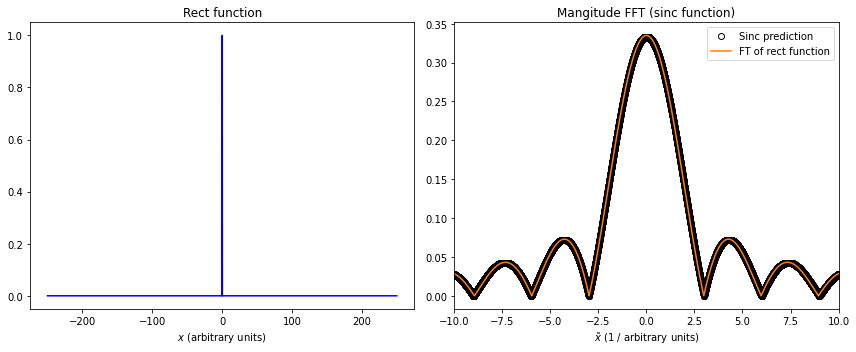

In [10]:
##Setup some sampling coords
num_samps = 100000
span = 500
reso = span / num_samps
coords = np.arange(-span/2, span/2, reso)

##Create an alpha scaling factor
alpha = 3

##Make the tophat (or rect) output
tophat = rect(alpha*coords)

##FT out tophat
fft_tophat = np.fft.fft(tophat)

##We know by definition that a rect function as defined above,
##should return a sinc function with an amplitude of 1.0
##at maximum. Due to the implementation of np.fft, we normalise
##in this case using the number of samples and coord span like this
norm = num_samps / span

##Find the DC term 
dc_term = fft_tophat[0]

##In this case, the dc_term and normalisation based on the 
##number of samples are the same. This depends on whether
##your input function (the rect) is symmetric about zero
print('DC term compared to calculated norm',dc_term, norm)

##Apply normalisation
fft_tophat = np.fft.fftshift(fft_tophat) / norm

##Get frequencies
ft_frequencies = np.fft.fftshift(np.fft.fftfreq(num_samps,reso))

##Make a prediction of output
##Apply the scaling factor appropriately
sinc_predict = (1/alpha)*np.sinc(ft_frequencies / alpha)

##Let's get plotting
fig,axs = plt.subplots(1,2,figsize=(12,5))

axs[0].plot(coords,tophat,color='Blue')
axs[0].set_title('Rect function')
axs[0].set_xlabel('$x$ (arbitrary units)')

axs[1].plot(ft_frequencies, abs(sinc_predict),'ko',mfc='none',label='Sinc prediction')
axs[1].plot(ft_frequencies,np.abs(fft_tophat),'C1',label='FT of rect function')

axs[1].set_xlabel(r'$\tilde{x}$ (1 / arbitrary units)')
axs[1].set_title('Mangitude FFT (sinc function)')

axs[1].legend()

##Set to a certain FT freq range
axs[1].set_xlim(-10,10)

plt.tight_layout()
# fig.savefig('tophat_FFT.png')
plt.show()

## Fourier transform in 2D
Right, so we're skipping ahead in FT theory here, but I want to get to interesting stuff to do with images and telescopes. You can FT in multiple dimensions, and the behaviour and scaling relationship are the same. Let's make a sky image of just a pixel, which is equivalent to a two dimensional `rect` function, and then FT it using `np.fft.fft2`.

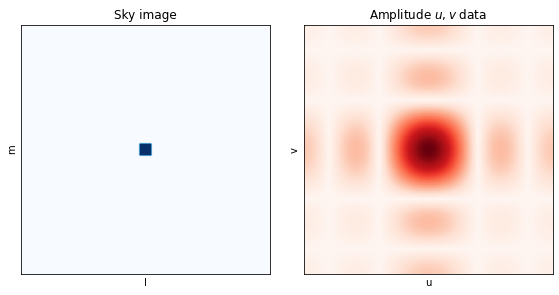

In [11]:
##Make a 2D rect function sky image
nside = 101
midpoint = int(np.floor(nside/2))
npix = 2
low = midpoint - npix
high = midpoint + npix + 1
image_rect = np.zeros((nside,nside))
image_rect[low:high,low:high] = 1.0

##Do the 2D FFT
uv_data = np.fft.fft2(image_rect)

##Again, apply a shift to get the zero
##frequency in the centre. numpy is able
##to understand the data is 2D
uv_data = np.fft.fftshift(uv_data)

##Let's make a plot and have a look

fig,axs = plt.subplots(1,2,figsize=(8,4))

im0 = axs[0].imshow(image_rect,cmap='Blues')
im1 = axs[1].imshow(np.abs(uv_data),cmap='Reds')

ims = [im0,im1]
titles = ['Sky image', 'Amplitude $u,v$ data']

for ind,ax in enumerate(axs):
    #add_colourbar(fig=fig,ax=ax,im=ims[ind])
    ax.set_title(titles[ind])
    ax.set_xticks([])
    ax.set_yticks([])
    
##Remeber from the radio interferometry lecture,
##the sky is in 'l,m' coords, and the FT is in
##'u,v' coords
axs[0].set_xlabel('l')
axs[0].set_ylabel('m')

axs[1].set_xlabel('u')
axs[1].set_ylabel('v')

plt.tight_layout()
plt.show()

So the result of the 2D FT is a `sinc` in both the $u$ and $v$ directions, that combine to make the 2D distribution.

## <font color='blue'> Ex 5.3 </font>
Convince yourself that we have a `sinc` function in both directions by plotting two 1D slices where $u=0$ and $v=0$, to see if they look like a `sinc` function. Don't worry about the normalisation, just look at the shape.


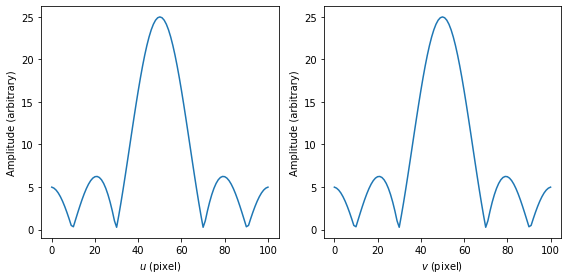

In [12]:
##Find the central pixel
middle_pix = nside // 2

##Slice to get the u=0, v=0
u_slice = np.abs(uv_data[middle_pix,:])
v_slice = np.abs(uv_data[:,middle_pix])

##Plotting time
fig,axs = plt.subplots(1,2,figsize=(8,4))

axs[0].plot(u_slice)
axs[1].plot(v_slice)

axs[0].set_xlabel('$u$ (pixel)')
axs[0].set_ylabel('Amplitude (arbitrary)')

axs[1].set_xlabel('$v$ (pixel)')
axs[1].set_ylabel('Amplitude (arbitrary)')

plt.tight_layout()
plt.show()

## FT and telescopes
Ok, getting you to code up loads of 2D FFTs and adding in telescope effects is going to a whole other notebook, and we want to cover as many topics as possible. So from here on, you're going to use a module I created for my lecture, and play around with telescope effects. Those that are interested can open up the `interferometric_stuff.py` module and check out what I've done. Documentation is limited (I've run out of time). We might do a notebook later where we improve the documentation, and make it an online API, so you have a template for your own future code (as in we'll learn how to make something like [this](https://shamfi.readthedocs.io/en/latest/shapelets.html) automatically from the code itself).

First off, let's repeat our `rect` image FT to 2D `sinc` using a class I made called `UVData_FromImage`.

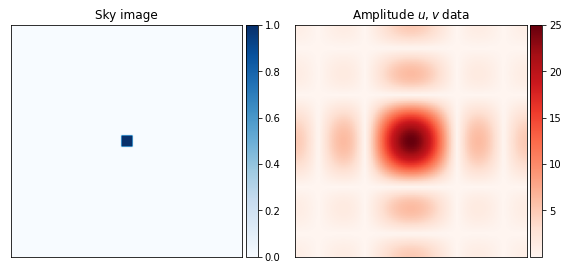

In [13]:
##Import everything inside
from interferometric_stuff import *

##Initialis a UVData_FromImage class, using our input image
uv_rect = UVData_FromImage(image_rect)
##Use the create_uvdata attribute to do the FT and create u,v data
##Returns a 2D complex array of u,v data
uvdata = uv_rect.create_uvdata()

##Use a function from interferometric_stuff that plots an image
##on the left, u,v data on the right
plot_image_left_uvdata_right(image_rect, uvdata)

We're going to be applying window effects to the $u,v$ data (the visibilities), so first of all, let's check our method to do an inverse FFT on the $u,v$ data recovers the image that we originally put in:

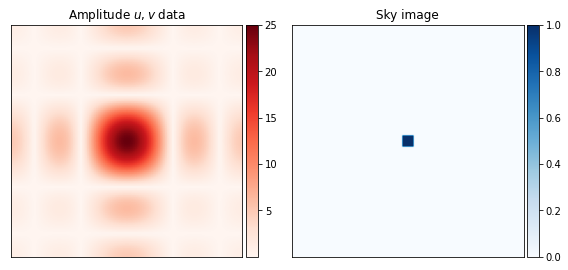

In [14]:
##Hidden attribute that a normal user isn't expected to use
##This function performs an iFFT on the stored visibilities
##Returns the recovered image
recovered_image = uv_rect._image_unmasked_uvdata()

##Another function that plots the uvdata on the left, image on the right
plot_uvdata_left_image_right(uv_data, recovered_image)

Time to mimic a dish/refractive telescope! Here we will apply a circular mask in $u,v$ space, and image the result. This is what a lens does.

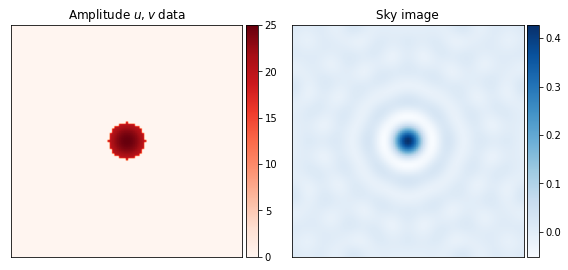

In [15]:
##This will apply a circular mask with a radius of 8
##to the u,v data, and return this masked data (as well
##storing the masked data in uv_rect)
masked_uvdata = uv_rect.apply_circ_mask(8)

##This attribute will image whatever masked data is inside
##uv_rect, and return the image
recovered_image = uv_rect.image_masked_uvdata()

##Have a look at what we've done
plot_uvdata_left_image_right(masked_uvdata, recovered_image)

## <font color='blue'> Ex 5.4 </font>
Using `uv_rect.apply_circ_mask` and `uv_rect.image_masked_uvdata`, try changing the radius of the circular mask to see how it effects the resultant sky image.

<font color='red'> VERY optional extension </font> Make a movie of a how a smaller and smaller circular mask causes worse and worse resolution. Try using [this](https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/) tutorial as a reference on how to make animations with matplotlib. This is hard.

<IPython.core.display.Javascript object>


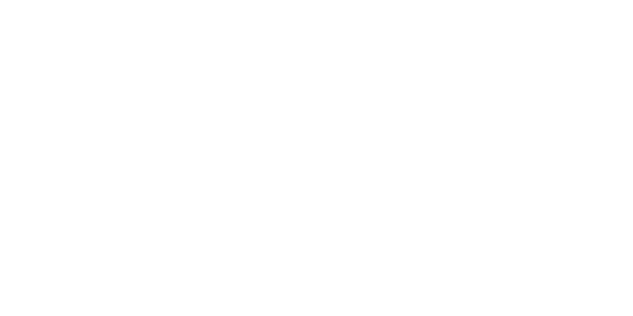

In [16]:
##Gotta include this to make animations work inside the notebook
%matplotlib notebook
%matplotlib notebook
from matplotlib.animation import FuncAnimation

##Setup the figure and axes for the movie
fig,axs = plt.subplots(1,2,figsize=(8,4))
im0 = axs[0].imshow(np.abs(uv_data),cmap='Reds')
im1 = axs[1].imshow(image_rect,cmap='Blues')

##We'll be defining functions to use with  
##FuncAnimation which will make our movie. You need
##to pass around whatever you are changing with
##each frame in these functions, so put both
##imshow objects in a list, and return them
##in the functions below
ims = [im0,im1]

plt.tight_layout()

##The FuncAnimation requires an initialising function
##to call, so we'll tidy up the figure, axes in this
##init function
def init():
    titles = ['Amplitude $u,v$ data','Sky image']
    for ind,ax in enumerate(axs):
        ax.set_title(titles[ind])
        ax.set_xticks([])
        ax.set_yticks([])
    
    return ims

##To use FuncAnimation, we supply it a function that
##takes a single number (frame) that updates the plots
##for each new frame
def update(frame):
    ##Create a new circular mask with radius=frame
    masked_uvdata = uv_rect.apply_circ_mask(frame)
    ##iFFT to recover the masked image
    recovered_image = uv_rect.image_masked_uvdata()
    
    ##The set_data attribute resets the data in a imshow image
    ims[0].set_data(np.abs(masked_uvdata))
    ims[1].set_data(recovered_image)
    ##This resets the vmin, vmax limits for an imshow image
    ims[1].set_clim(recovered_image.min(),recovered_image.max())
    return ims

##Use the FuncAnimation to make a movie! Need to give it a figure,
##the update function defined above, a number of frames to iterate
##over.
##blit is an optional argument that means only parts of the image
##that need to be rewritten are, to save processing
##repeat means the animation will loop
ani = FuncAnimation(fig, update, frames=np.arange(4,50,1)[::-1],
                        init_func=init, blit=True, repeat=True)

## Spatial Scales
If you haven't watched the radio astronomy lecture I gave, this might not make too much sense. So go and watch it and ALL the other lectures now.

Ok, so I described how the FT of image space are called visibilities, and those with a large values of $u,v$ (towards the edge of the $u,v$ data plane) give the fine detail of the image, and those with small values of $u,v$ (the centre of the $u,v$ plane) give the broad details of the image. These are referred to as spatial scales.

When applying a circular mask, we retain the small spatial scales, which throws away that large spatial scales, and so we loose resolution. Let's do the opposite, and throw away the small spatial scales by using `uv_rect.apply_inverse_circ_mask`:

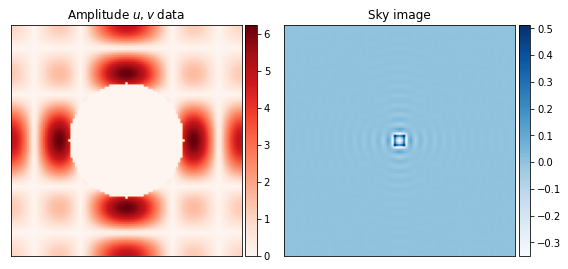

In [45]:
%matplotlib inline
##This will apply a circular mask with a radius of 8
##to the u,v data, and return this masked data (as well
##storing the masked data in uv_rect)
##This time it will set everything inside the cicle
##to zero
masked_uvdata = uv_rect.apply_inverse_circ_mask(25)

##This attribute will image whatever masked data is inside
##uv_rect, and return the image
recovered_image = uv_rect.image_masked_uvdata()

##Have a look at what we've done
plot_uvdata_left_image_right(masked_uvdata, recovered_image)

Two things that are interesting here: 1) We basically have the outline of a square now, instead of a filled square, because the edge is a fine detail 2) Our image has gone negative in places, and that's because we are missing spatial scales.

## <font color='blue'> Ex 5.5 </font>
Along with this notebook, there should be a text file called `byoda.txt`, which contains a 2D image. Read it in as a numpy array, and make a `UVData_FromImage` object from it. Make three plots: one of the raw image and uv_data, one with a circular mask and recovered image, and one with an inverse circular mask and recovered image. If you want your image to be plotted in black and white, try supplying `img_cmap='gray'` to the plotting commands. Try wrapping the uv_data in the `np.log10` function to see details in the uv_data.

<ipython-input-18-e13126bba811>:22: RuntimeWarning: divide by zero encountered in log10
  plot_uvdata_left_image_right(np.log10(masked_uvdata), recovered_image, img_cmap='gray')
<ipython-input-18-e13126bba811>:35: RuntimeWarning: divide by zero encountered in log10
  plot_uvdata_left_image_right(np.log10(masked_uvdata), recovered_image, img_cmap='gray')


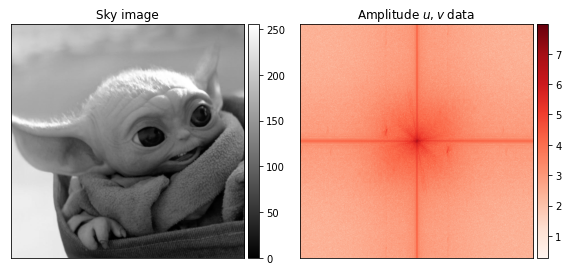

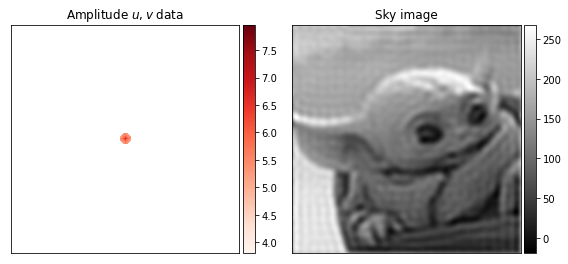

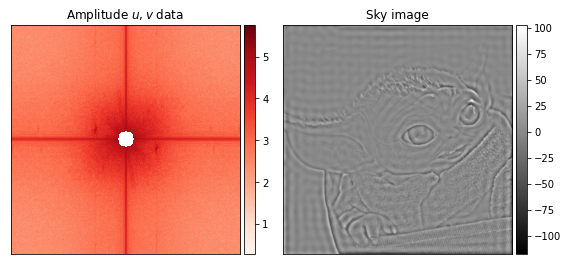

In [18]:
##Read in data
byoda = np.loadtxt('byoda.txt')

##Make a UVData_FromImage object and FT to make uv_data
uv_byoda = UVData_FromImage(byoda)
uv_data = uv_byoda.create_uvdata()

##Plotting times
plot_image_left_uvdata_right(byoda, np.log10(uv_data), img_cmap='gray')

##This will apply a circular mask with a radius of 8
##to the u,v data, and return this masked data (as well
##storing the masked data in uv_rect)
##This time it will set everything inside the cicle
##to zero
masked_uvdata = uv_byoda.apply_circ_mask(25)

##This attribute will image whatever masked data is inside
##uv_rect, and return the image
recovered_image = uv_byoda.image_masked_uvdata()

plot_uvdata_left_image_right(np.log10(masked_uvdata), recovered_image, img_cmap='gray')

##This will apply a circular mask with a radius of 8
##to the u,v data, and return this masked data (as well
##storing the masked data in uv_rect)
##This time it will set everything inside the cicle
##to zero
masked_uvdata = uv_byoda.apply_inverse_circ_mask(25)

##This attribute will image whatever masked data is inside
##uv_rect, and return the image
recovered_image = uv_byoda.image_masked_uvdata()

plot_uvdata_left_image_right(np.log10(masked_uvdata), recovered_image, img_cmap='gray')

## MWA telescope
This is for the interested, as I realise there has already been a large amount content in this notebook. Let's see what an interferometer does in $u,v$ space. First off all, let's load in some position coordinates of the original MWA telescope array layout and have a look:

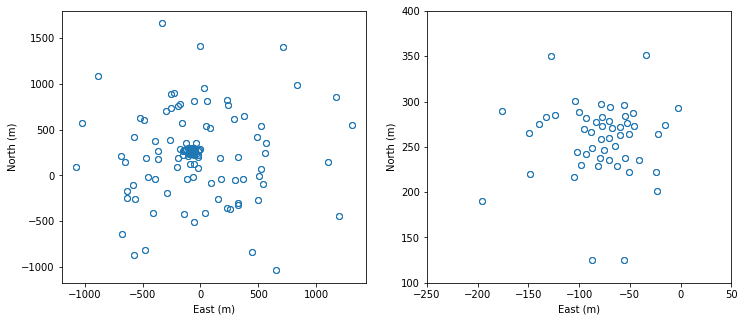

In [19]:
##Load in the data
east, north, height = np.loadtxt('MWA_enh_layout.txt',unpack=True)


fig,axs = plt.subplots(1,2,figsize=(12,5))

for ax in axs:
    ax.plot(east,north,'C0o',mfc='none')
    ax.plot(east,north,'C0o',mfc='none')
    ax.set_xlabel('East (m)')
    ax.set_ylabel('North (m)')

width = 300
x = -250
y = 100
ax.set_xlim(x,x+width)
ax.set_ylim(y,y+width)

plt.show()

Each circle represents a recieving element. The combined signals of the recievers are the visibilities, which are the FT of image space. I have built in functionality to read in these `east`, `north`, `height` coords, convert them into $u,v$ coords (pointed at zenith), and to apply them as a mask, to mimic the effects of an interferometer. First off, we'll plot the $u,v$ coords the MWA samples, and then we'll plot what that's done to our image:

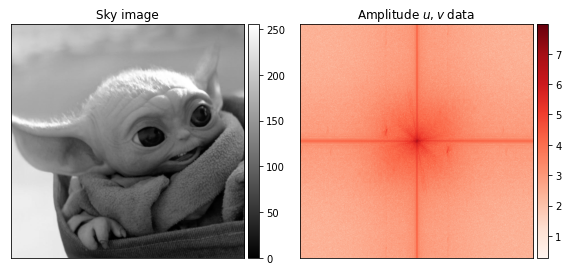

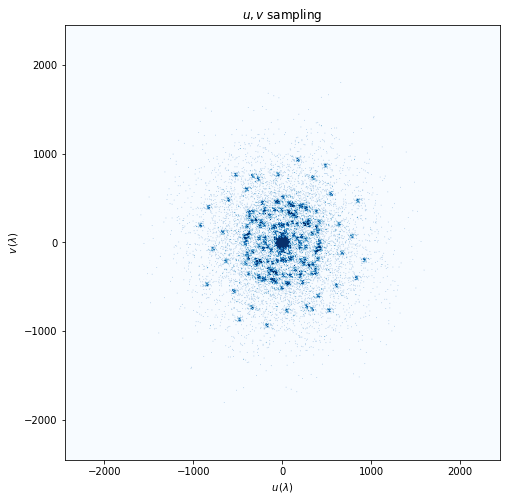

<ipython-input-27-66837633d82e>:32: RuntimeWarning: divide by zero encountered in log10
  plot_uvdata_left_image_right(np.log10(masked_uvdata), recovered_image, img_cmap='gray')


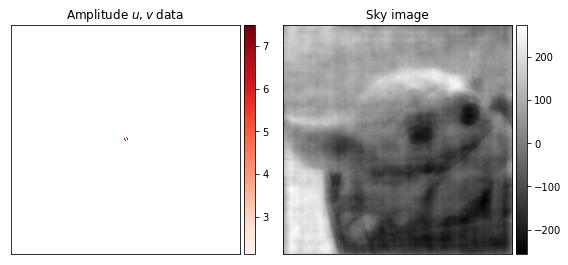

In [27]:
##Read in data
byoda = np.loadtxt('byoda.txt')

##Make a UVData_FromImage object and FT to make uv_data
uv_byoda = UVData_FromImage(byoda)
uv_data = uv_byoda.create_uvdata()

##Plot what we started with
plot_image_left_uvdata_right(byoda, np.log10(uv_data), img_cmap='gray')

##This takes the east, north, height coords, converts them to $u,v$,
##grids them onto a mask, returns that mask, and the mask applied to
##the visibilities
uv_mask, masked_uvdata = uv_byoda.apply_enh_mask(east, north, height)

##Plot the mask
fig,axs = plt.subplots(1,1,figsize=(8,8))

##When you run apply_enh_mask, it creates a range of u coords to
##create the mask over - we can use that to see how high our
##u,v coordinates go in the imshow plot
u_low = uv_byoda.u_range[0]
u_high = uv_byoda.u_range[-1]

##The extent keyword let's you set the tick labels on an imshow plot
axs.imshow(uv_mask,cmap='Blues',extent=[u_low,u_high,u_low,u_high],vmin=0,vmax=1.0)
axs.set_title('$u,v$ sampling')

axs.set_xlabel('$u\,(\lambda)$')
axs.set_ylabel('$v\,(\lambda)$')

plt.show()

##Have a look at our baby yoda image through the MWA:
recovered_image = uv_byoda.image_masked_uvdata()
plot_uvdata_left_image_right(np.log10(masked_uvdata), recovered_image, img_cmap='gray')

We can see the broad image structures, but have lost some detail. The original layout of the MWA was designed with having sensitivity to large-scale structure in mind (due to Epoch of Reionisation science needing it), and so you can see the fact there are lots of short baselines (that central cluster in the east,north plot) allows the large scales to be easily reconstructed in the image.

## <font color='blue'> (Optional) Ex 5.6 </font>
Try making up some array layouts, and seeing what it does to your image! The east, north, and height arrays must all the same length. You can set the height array to all zeros, which just means your array is sat on a flat piece of ground. The larger your maximum east/north coords, the better resolution you will have. The more baselines you have, the better the overall sensitivity as well. But beware, as you increase the number of baselines, the more computationally intense it will be to calculate and grid your $u,v$ data points.

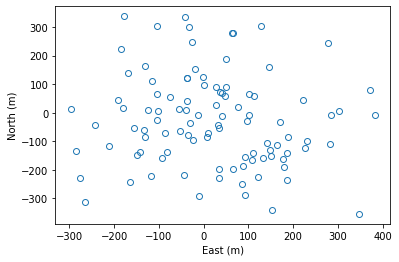

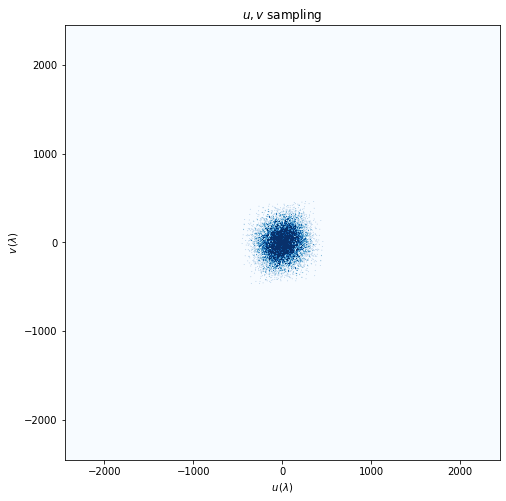

<ipython-input-43-de8714a5873d>:43: RuntimeWarning: divide by zero encountered in log10
  plot_uvdata_left_image_right(np.log10(masked_uvdata), recovered_image, img_cmap='gray')


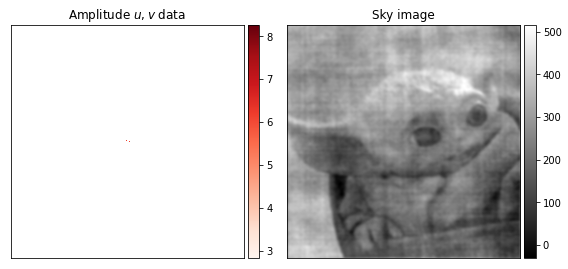

In [43]:


num_recievers = 100


# max_north = 1500
# max_east = 1500

# east = np.random.randint(-max_east, max_east, num_recievers)
# north = np.random.randint(-max_north, max_north, num_recievers)
# height = np.zeros(num_recievers)

max_north = 150
max_east = 150

east = np.random.normal(0, max_east, num_recievers)
north = np.random.normal(0, max_north, num_recievers)
height = np.zeros(num_recievers)


plt.plot(east,north,'C0o',mfc='none')
plt.xlabel('East (m)')
plt.ylabel('North (m)')

plt.show()

uv_mask, masked_uvdata = uv_byoda.apply_enh_mask(east, north, height)

##Plot the mask
fig,axs = plt.subplots(1,1,figsize=(8,8))

u_low = uv_byoda.u_range[0]
u_high = uv_byoda.u_range[-1]

axs.imshow(uv_mask,cmap='Blues',extent=[u_low,u_high,u_low,u_high],vmin=0,vmax=1.0)
axs.set_title('$u,v$ sampling')

axs.set_xlabel('$u\,(\lambda)$')
axs.set_ylabel('$v\,(\lambda)$')

plt.show()

##Have a look at our baby yoda image through the MWA:
recovered_image = uv_byoda.image_masked_uvdata()
plot_uvdata_left_image_right(np.log10(masked_uvdata), recovered_image, img_cmap='gray')